## Bayesian Classification fitting with Metropolis-Hastings

Disclaimer: 
<br> This solution is showcased to share my understanding of the problem and my own approach to it.
<br> This solution is not intended for any general application.

#### For questions, suggestions and further details, please feel free to contact me at juan-carlos.ramirez@warwick.ac.uk

---------

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
sns.set_theme() # Seaborn template
plt.rcParams['figure.figsize'] = [10, 5] # Default to bigger plots
# Import training and test data provided by Richard
path = '7.1 Bayesian classification data/'
X_test, X_train  = pd.read_csv(path+'x_test.csv'), pd.read_csv(path+'x_train.csv')
Y_test, Y_train = pd.read_csv(path+'y_test.csv'), pd.read_csv(path+'y_train.csv')
# Clean data from unwanted columns
X_test, X_train = X_test.set_index('Unnamed: 0'), X_train.set_index('Unnamed: 0')
Y_test, Y_train = Y_test.set_index('Unnamed: 0'), Y_train.set_index('Unnamed: 0')
# Give matrix format and add intercept
Y_test, X_test = Y_test.x.values, np.c_[np.ones(len(X_test)),X_test.values]
Target, DesignMatrix = Y_train.x.values, np.c_[np.ones(len(X_train)),X_train.values]

## Functions
-------------------------------

In [2]:
# //////////////////////////////////////////////// Y's Conditional Mass Function /////////////////////
def Y_Mass(z):
    return np.exp(z) / sum(np.exp(z))

In [3]:
# //////////////////////////////////////// Data Log-Likelihood Function USED FOR TASK 1 //////////////
def Data_LogLikelihood(Y, x, B, GetState=False):
    if B.ndim < 2:
        xB = x @ np.array([B[0:3],B[3:6],B[6:9]]) # (x^T)B
        if GetState:
            return [ np.log( Y_Mass( xB[r] ) )[ GetState - 1 ] for r in range( len(xB) )]
        else:
            return sum([ np.log( Y_Mass( xB[r] ) )[ Y[r] - 1 ] for r in range( len(xB) )])
    elif len(x) < 2:
        result = np.zeros(1)
        for r in range(len(B)):
            rB = B[r]
            xB = x @ np.array([rB[0:3],rB[3:6],rB[6:9]])
            if GetState:
                result = np.row_stack([result,[ np.log( Y_Mass( xB[i] ) )[ GetState - 1 ] 
                                               for i in range( len(xB) )]])
            else:
                return 'Multi dimensional Beta only compatible with GetState=True'
        return result[1:] 

In [4]:
# /////////////////////////////////////////////// Metropolis-Hastings Algorithm ///////////////////////
def Metropolis_Hastings(Iterations, Burn_In, Param_Dim, Prior_S, Proposal_S):
    BetaPrior = stats.multivariate_normal([0]*Param_Dim, Prior_S) # Beta Prior
    B_prev = BetaPrior.rvs(1)
    Betas = np.zeros(9)
    acc = 0
    for _ in range(Iterations):
        B_new = stats.multivariate_normal(B_prev, Proposal_S).rvs(1) # Sample Parameter vector B
        pB_new = BetaPrior.logpdf(B_new) # Log-likelihood B_New under the prior
        pB_prev = BetaPrior.logpdf(B_prev) # Log-likelihood of B_prev under prior
        qB_new = stats.multivariate_normal.logpdf(B_new, B_prev, Proposal_S) # Log-l of B_new
        qB_prev = stats.multivariate_normal.logpdf(B_prev, B_new, Proposal_S) # Log-l of B_prev
        llData_NB = Data_LogLikelihood(Target, DesignMatrix, B_new) # Log-L of data | B_New
        llData_PB = Data_LogLikelihood(Target, DesignMatrix, B_prev) # Log-L of data | B_prev
        if np.log(np.random.uniform(0,1)) < min(np.log(1), (llData_NB + pB_new + qB_prev) - \
                                                           (llData_PB + pB_prev + qB_new) ):
            acc += 1
            B_prev = B_new
            if _ > Burn_In : Betas = np.row_stack([Betas,B_new])            
        else:
            if _ > Burn_In : Betas = np.row_stack([Betas,B_prev])
    return pd.DataFrame(Betas[1:,:]), round(acc/(Iterations-Burn_In),4)*100

## Preparation
We execute the Metropolis Hastings Algorithm using the functions defined in the previous cell as preparation for Tasks 1 to 6

-----------------

In [5]:
# Import Trained Sigma_q (200,000 iterations, 100,000 Burnt, Initial Sigma_q = np.eye(d)*.1)
Sigma_q = pd.read_csv(path+'Sigma_q.csv',header=None).values
Betas, Acc_Ratio = Metropolis_Hastings(Iterations=50000, Burn_In=50000//10, Param_Dim=9,
                                       Prior_S=np.eye(9)*100, Proposal_S=Sigma_q)

---------
### Task 1: Calculate the Log-Likelihood of Target given DesignMatrix and B = [1,1,1,1,1,1,1,1,1]

In [6]:
print('Data Log-Likelihood assuming B = [1,1,1,1,1,1,1,1,1]:',
      round(Data_LogLikelihood(Target, DesignMatrix, np.array([1,1,1,1,1,1,1,1,1,1])),4))

Data Log-Likelihood assuming B = [1,1,1,1,1,1,1,1,1]: -163.6932


---------
### Task 2: Display the Optimal Proposal Covariance Matrix and the MH acceptance ratio using it. 

In [7]:
print('Optimal Proposal Covariance Matrix diagonal:',[round(Sigma_q[i,i],2) for i in range(len(Sigma_q))])
print('Acceptance ratio under Sigma q: ',Acc_Ratio,'%')

Optimal Proposal Covariance Matrix diagonal: [6.69, 9.05, 24.87, 0.94, 1.02, 4.84, 4.8, 4.89, 8.38]
Acceptance ratio under Sigma q:  39.160000000000004 %


---------
### Task 3: Iterations and Burn-In needed to get an ESS greater than 1000 using the Betas Matrix

In [8]:
# The following was verified using the R code provided by Richard using the "Betas" matrix obtained from the MH Algorithm
print ('Burn',50000//10,'and run',50000-50000//10,'iterations afterwards to get an ESS consistently greater than 1000')

Burn 5000 and run 45000 iterations afterwards to get an ESS consistently greater than 1000


---------
### Task 4: Plot the histogram of the final value of B

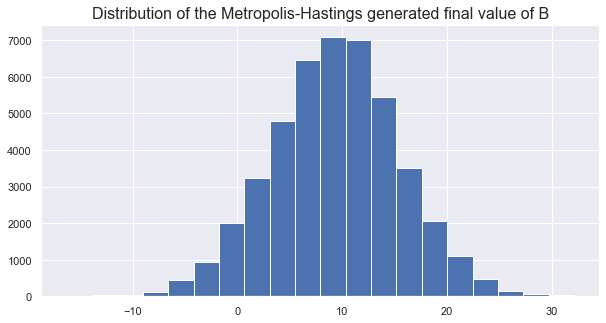

In [9]:
Betas.loc[:,8].hist(bins=20)
plt.title('Distribution of the Metropolis-Hastings generated final value of B',size=16)
plt.show()

---------
### Task 5: Plot the distribution of the Log-Probability of the test point being in state 1 (Versicolor)

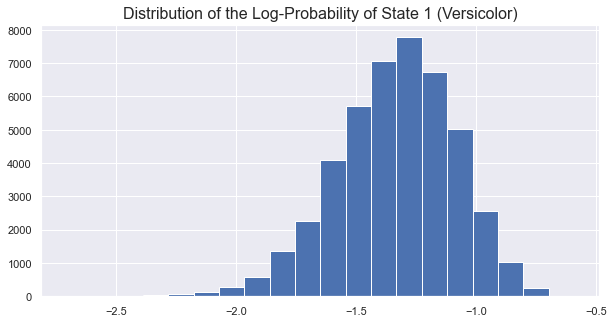

In [10]:
LogP1_Posterior = Data_LogLikelihood(None, X_test, Betas.values, GetState=1)
plt.hist(LogP1_Posterior,bins=20)
plt.title('Distribution of the Log-Probability of State 1 (Versicolor)',size=16)
plt.show()

---------
### Task 6: Estimate the expected probability of the test point being in state 1

In [11]:
print('Expected probability of',X_test[0],'being a Versicolor:',round(np.mean(np.exp(LogP1_Posterior))*100,4),'%')

Expected probability of [1.  6.7 3.1] being a Versicolor: 27.0971 %
